In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm
import config
import process_data

In [2]:
# define ivim function
def ivim(b, Dp, Dt, Fp):
    return Fp*np.exp(-b*Dp) + (1-Fp)*np.exp(-b*Dt)

# apply mask: only keep vox with mask = 1

**Single subject Data 100206**

In [3]:
scan = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')

In [4]:
mask = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [5]:
scan_dimension = scan.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [6]:
print(x, y, z, b)

print('The shape of scan: ')
print(scan.shape)
print('The shape of mask: ')
print(mask.shape)

print(type(scan), type(mask))

145 174 145 288
The shape of scan: 
(145, 174, 145, 288)
The shape of mask: 
(145, 174, 145)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [7]:
scan_long = np.reshape(scan, (x*y*z, b))

In [8]:
mask_long = np.reshape(mask, (x*y*z, 1))

In [9]:
scan_long_no_background, background_voxel_arr = process_data.trim_background(scan_long, mask_long)

In [10]:
scan_long_no_bg_0_arr = np.argwhere(scan_long_no_background == 0)

In [11]:
scan_long_no_bg_0_arr

array([[   147,    245],
       [   352,    276],
       [   423,    128],
       ...,
       [936166,    223],
       [936224,    240],
       [936228,    256]])

In [12]:
scan_long_no_bg_cp = scan_long_no_background

In [ ]:
def check_0(scan_long_no_bg):
    x = len(scan_long_no_bg)
    Sb_0_idx_arr = []
    for idx in range(x):
        Sb_arr = scan_long_no_bg[idx]
        if Sb_arr[0] == 0.:
            print(Sb_arr)
            Sb_0_idx_arr.append(idx)
    Sb_0_idx_arr = np.array(Sb_0_idx_arr)
    return scan_long_no_bg

In [ ]:
scan_long_no_background = trim_0(scan_long_no_background)

In [ ]:
# Abnormal cases

# scan_long_no_background[229768]
# scan_long_no_background[536137]
scan_long_no_background[850262]

In [12]:
np.argwhere(np.isnan(scan_long_no_background))

array([], shape=(0, 2), dtype=int64)

In [13]:
# normalized_scan_long_no_background = process_data.normalize_scan2(scan_long_no_background)

In [ ]:
# scan_long_no_background[88184,:]
# scan_long_no_background[96165,:]

# 0/0 is nan, N/0 is inf

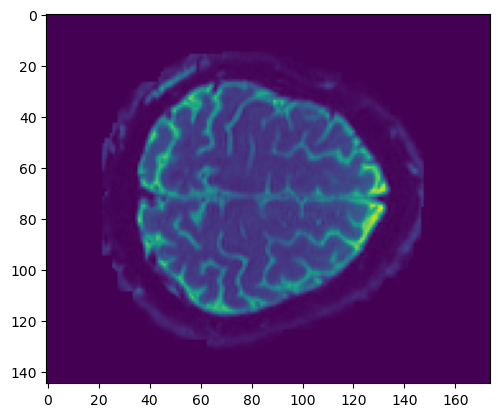

In [17]:
plt.imshow(scan[:,:,100, 0])

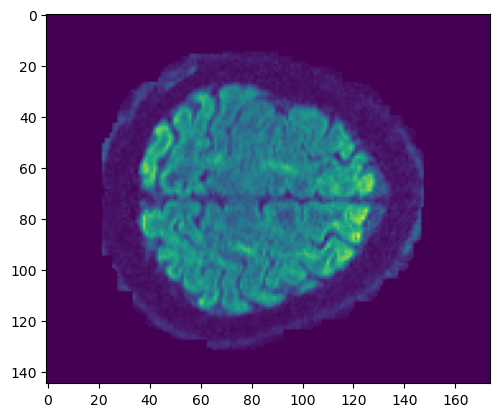

In [16]:
plt.imshow(scan[:,:,100, 1])

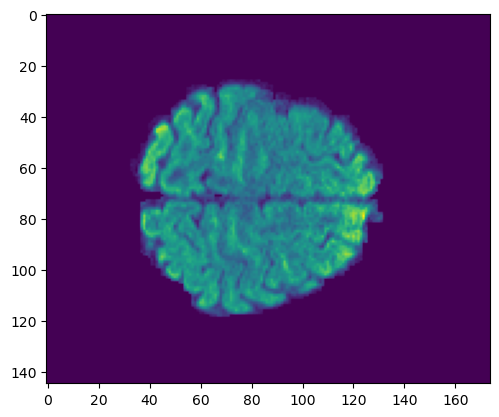

In [42]:
plt.imshow(scan[:,:,100, 10]*mask[:,:,100])

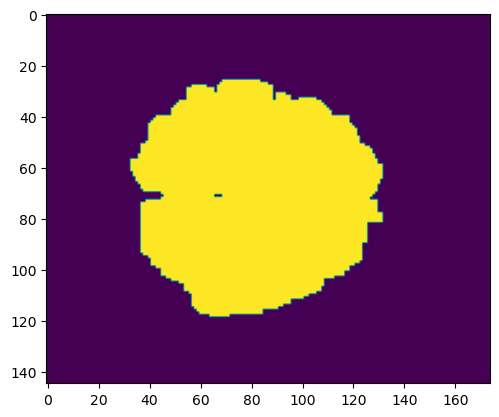

In [43]:
plt.imshow(mask[:,:,100])

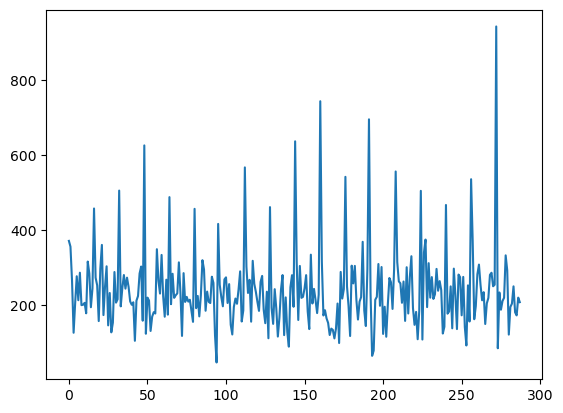

In [15]:
plt.plot(scan_long_no_background[100,:])
# plt.plot(scan_long_no_bg[96165,:])

In [13]:
bval_list = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [ ]:
plt.plot(bval_list, scan_long_no_background[0,:])

In [14]:
print(np.where(bval_list == 5))

(array([  0,  16,  32,  48,  64,  80,  95, 112, 128, 144, 160, 176, 191,
       208, 224, 240, 256, 272]),)


In [15]:
print(type(bval_list))
print(bval_list)

<class 'numpy.ndarray'>
[   5. 1000. 1995. 3005.  995. 2995. 2005.  990. 1990. 3000. 1000. 1985.
 2995. 1005. 1995. 2995.    5.  995. 2000. 3010. 3005.  995. 2005.  995.
 1990. 2985. 1005. 2000. 3005.  995. 1995. 2990.    5. 3005.  995. 2000.
  990. 1990. 2990.  995. 2985. 1995. 3005.  995. 2005. 1000. 1990. 2995.
    5. 1005. 2005. 2995. 3000. 1005. 1985. 1005. 2985. 2005.  995. 1990.
 3005. 1000. 2990. 2000.    5.  990. 2005. 2995. 1000. 2005. 3000.  995.
 2005. 3005. 1005. 2000. 3010.  990. 2005. 1995.    5. 1000. 3010. 2985.
 1005. 1995. 3000. 1000. 2005. 3000.  990. 2005. 2990. 3000. 1000.    5.
 2990.  995. 1995. 1995. 1005. 2000. 2995. 1005. 2010. 2995. 1005. 2000.
 3010. 1000. 2005. 2990.    5.  990. 2985. 2005. 1000. 2005. 2985.  995.
 2005. 2990.  995. 2005. 2990. 1005. 2000. 3005.    5.  995. 2995. 1990.
 1005.  995. 2005. 2990. 2000. 3000. 1000. 2005. 2985.  990. 1995. 2985.
    5.  990. 2000. 3010.  995. 1990. 2995. 1005. 2000. 3005. 1000. 1990.
 2995. 2000.  995. 2990.   

In [16]:
S0 = process_data.get_S0(scan_long_no_background, bval_list)

In [19]:
np.save('S0_.npy',S0)
# S0 = np.load('S0_.npy')

In [17]:
print(S0)

[[450.87282308]
 [454.07630242]
 [473.0456704 ]
 ...
 [871.7351515 ]
 [643.40559726]
 [882.28022257]]


In [45]:
def get_0_S0(S0):
    S0_0_idx_arr = []
    l = len(S0)
    for i in range(l):
        if S0[i][0] >= 0 and S0[i][0] < 1:
            S0_0_idx_arr.append(i)
    S0_0_idx_arr = np.array(S0_0_idx_arr)
    return S0_0_idx_arr

In [52]:
S0_0_idx_arr = get_0_S0(S0)

In [54]:
print(S0_0_idx_arr)

[ 88184  96165 104386 104471 112589 112845 112930 121280 121706 130165
 130591 133084 139400 139753 148444 148806 149838 151227 159177 159511
 160888 160932 167928 169004 169341 172164 172704 179261 182142 188564
 189253 189586 192778 199046 199391 199725 208912 209605 209942 212326
 220226 229542 229891 239966 240315 243987 253501 253502 253507 254608
 274877 285638 285841 288331 296550 297552 297635 299180 308227 308301
 309369 310079 318538 318539 318566 318804 320401 329456 329457 329466
 329467 329616 329733 330192 331330 331333 331734 340434 340444 340445
 340560 340593 340711 341171 342907 351387 351388 351412 351679 362332
 362335 365318 373335 376393 384021 397772 430006 459603 469833 480031
 480035 480072 490302 490307 490346 522619 534970 535061 536586 547993
 555435 555822 557133 558594 559130 566652 577644 581139 588712 600802
 600893 621735 621868 632336 642619 653883 704493 705799 728026 737677
 750802 751057 753906 754737 754789 764561 764613 764664 774292 774343
 79142

In [53]:
scan_long_no_bg = np.delete(scan_long_no_background, S0_0_idx_arr, 0)

In [57]:
S0_ = np.delete(S0, S0_0_idx_arr, 0)

In [59]:
print(scan_long_no_bg.shape)
print(S0_.shape)

(936085, 288)
(936085, 1)


In [60]:
normalized_scan_long_no_background = process_data.normalize_scan(scan_long_no_bg, S0_)

In [61]:
np.argwhere(np.isnan(normalized_scan_long_no_background))

array([], shape=(0, 2), dtype=int64)

In [64]:
np.save('normalized_scan_long5.npy', normalized_scan_long_no_background)

In [88]:
np.argwhere(normalized_scan_long_no_background > 80).shape

(5423, 2)

In [74]:
print(normalized_scan_long_no_background[768126])
print(S0[768126])

scan_long_no_bg[]

# print(scan_long_no_bg_cp[164196])

[ 0.         14.31580974 30.61078917 43.65978298 16.80746949 53.90457561
 26.28237    19.30478691 50.2242166  76.16447576 64.58823719 27.75161002
 39.03989339 42.76344781 49.21149646 51.29434938  0.         32.1840743
 35.53089902 25.91163779 25.02787013 16.98304595 42.8797852   4.94577284
 26.41612726 63.45132688 35.35725772  9.06512356 54.75509891 24.37509015
 34.15356647 27.68386745  0.         38.01505258 72.05536705 52.95614907
 20.90105273 41.45339909 24.78962941 42.54745381 58.60415853 30.43942113
 27.77665329 51.24578513 44.51802314 15.39891949 42.05331975 51.47092316
  0.         61.95700112 29.29293864 59.81165215 43.33122676  0.
 40.46266063 22.56667347 43.26948846 43.5349098  21.17561129 50.6461601
 36.49266272 15.01093052 50.30452158 46.76165593  0.         16.37773946
 47.04246681 48.60709724 12.83621857 33.81026293 19.95001822 11.11364391
 25.1709464   9.87517156 36.58347093 32.63997064 27.17197883 12.29089701
  9.86627644 34.00968147  0.         14.8796657  45.65108013 

In [ ]:
np.argwhere(np.isinf(normalized_scan_long_no_background))

In [ ]:
normalized_scan_long_no_background = np.load('normalized_scan_long5.npy')

## Neural Network Training

Let's create the neural network class and instantiate it.

In [75]:
class Net(nn.Module):
    def __init__(self, b_values_no0):
        super(Net, self).__init__()

        self.b_values_no0 = b_values_no0
        self.fc_layers = nn.ModuleList()
        for i in range(3): # 3 fully connected hidden layers
            self.fc_layers.extend([nn.Linear(len(b_values_no0), len(b_values_no0)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values_no0), 3))

    def forward(self, X):
        # print('x')
        # print(X.shape)
        params = torch.abs(self.encoder(X)) # Dp, Dt, Fp
        # print(params.shape)
        # print(params)
        Dp = params[:, 0].unsqueeze(1)
        Dt = params[:, 1].unsqueeze(1)
        Fp = params[:, 2].unsqueeze(1)

        X = Fp*torch.exp(-self.b_values_no0*Dp) + (1-Fp)*torch.exp(-self.b_values_no0*Dt)

        return X, Dp, Dt, Fp

In [76]:
net = Net(bval_list)
print(net)

Net(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=3, bias=True)
  )
)


In [77]:
# Network
b_values = torch.FloatTensor(bval_list)
net = Net(b_values)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)  

In [78]:
print(b_values.shape)
print(b_values.type)

torch.Size([288])
<built-in method type of Tensor object at 0x17de5eed0>


Create batch queues.

In [79]:
# batch_size = 128
# num_batches = len(normalized_scan_long_no_background) // batch_size
# # X_train = X_train[:,1:] # exlude the b=0 value as signals are normalized
# trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_long_no_background.astype(np.float32)),
#                                 batch_size = batch_size, 
#                                 shuffle = True,
#                                 num_workers = 2,
#                                 drop_last = True)
batch_size = 128
num_batches = len(normalized_scan_long_no_background) // batch_size
# X_train = X_train[:,1:] # exlude the b=0 value as signals are normalized
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_long_no_background.astype(np.float32)),
                                batch_size = batch_size, 
                                shuffle = True,
                                num_workers = 2,
                                drop_last = True)

Train, this might take a few minutes.

In [80]:
# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

# Train
counter = 0
for epoch in range(1000): 
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # print('Running_loss: ', running_loss)
        # print('X_batch: ')
        # print(X_batch.shape)
        # print(X_batch)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        X_pred, Dp_pred, Dt_pred, Fp_pred = net(X_batch)
        # print('X_pred: ')
        # print(X_pred.shape)
        # print(X_pred)
        if i == 8 and counter == 10:
            print(X_pred)
        loss = criterion(X_pred, X_batch)
        loss.backward()
        optimizer.step()
        # print('loss: ', loss.item())
        running_loss += loss.item()

    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/len(trainloader)))
    # early stopping
    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1
print("Done")
# Restore best model
net.load_state_dict(final_model)
#        DP            Dt           Fp

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:37<00:00, 194.97it/s]


Loss: 5256.487659238279
Average Loss: 0.7187867713986433
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:38<00:00, 189.77it/s]


Loss: 5227.207325220108
Average Loss: 0.7147828969260369
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:37<00:00, 193.78it/s]


Loss: 5215.334546245635
Average Loss: 0.7131593800417934
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:36<00:00, 200.58it/s]


Loss: 5226.840455934405
Average Loss: 0.714732730197512
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 1


100%|██████████████████████████████████████| 7313/7313 [00:35<00:00, 205.85it/s]


Loss: 5148.50576094538
Average Loss: 0.704021025700175
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:40<00:00, 181.41it/s]


Loss: 4970.712775507942
Average Loss: 0.6797091173947685
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:41<00:00, 177.10it/s]


Loss: 4693.679431816563
Average Loss: 0.6418268059369018
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:39<00:00, 183.96it/s]


Loss: 4715.378565938212
Average Loss: 0.6447940060082336
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 1


100%|██████████████████████████████████████| 7313/7313 [00:42<00:00, 172.25it/s]


Loss: 4677.308724084869
Average Loss: 0.639588229739487
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:40<00:00, 178.79it/s]


Loss: 4716.965328807943
Average Loss: 0.6450109843850599
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 1


  1%|▏                                        | 37/7313 [00:02<04:26, 27.28it/s]

tensor([[0.9648, 0.2737, 0.1513,  ..., 0.2729, 0.1513, 0.0832],
        [0.9578, 0.3344, 0.1954,  ..., 0.3335, 0.1954, 0.1135],
        [0.9659, 0.4841, 0.4146,  ..., 0.4837, 0.4146, 0.3545],
        ...,
        [0.9636, 0.4980, 0.4260,  ..., 0.4976, 0.4260, 0.3638],
        [0.9666, 0.3981, 0.2858,  ..., 0.3975, 0.2858, 0.2044],
        [0.9685, 0.2294, 0.1448,  ..., 0.2289, 0.1448, 0.0910]],
       grad_fn=<AddBackward0>)


100%|██████████████████████████████████████| 7313/7313 [00:36<00:00, 198.58it/s]


Loss: 4618.042577008717
Average Loss: 0.6314840116243289
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:37<00:00, 193.27it/s]


Loss: 4734.2097979765385
Average Loss: 0.6473690411563706
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 1


100%|██████████████████████████████████████| 7313/7313 [00:40<00:00, 178.87it/s]


Loss: 4675.006198553368
Average Loss: 0.6392733759815901
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 2


100%|██████████████████████████████████████| 7313/7313 [00:40<00:00, 182.46it/s]


Loss: 4686.145635644905
Average Loss: 0.6407966136530706
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 3


100%|██████████████████████████████████████| 7313/7313 [00:42<00:00, 173.19it/s]


Loss: 4739.26632725168
Average Loss: 0.6480604850610803
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 4


100%|██████████████████████████████████████| 7313/7313 [00:41<00:00, 174.32it/s]


Loss: 4792.5641971714795
Average Loss: 0.6553485843253767
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 5


100%|██████████████████████████████████████| 7313/7313 [00:40<00:00, 182.63it/s]


Loss: 4700.457595814019
Average Loss: 0.6427536709714234
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 6


100%|██████████████████████████████████████| 7313/7313 [00:36<00:00, 198.93it/s]


Loss: 4626.366100221872
Average Loss: 0.63262219338464
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 7


100%|██████████████████████████████████████| 7313/7313 [00:36<00:00, 199.84it/s]


Loss: 4651.162252480164
Average Loss: 0.6360128883468021
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 8


100%|██████████████████████████████████████| 7313/7313 [00:36<00:00, 198.18it/s]


Loss: 4590.243258005939
Average Loss: 0.6276826552722466
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:40<00:00, 181.22it/s]


Loss: 4606.003902540542
Average Loss: 0.629837809727956
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 1


100%|██████████████████████████████████████| 7313/7313 [00:40<00:00, 181.13it/s]


Loss: 4615.01358478982
Average Loss: 0.6310698187870669
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 2


100%|██████████████████████████████████████| 7313/7313 [00:37<00:00, 196.56it/s]


Loss: 4628.685965841636
Average Loss: 0.6329394182745297
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 3


100%|██████████████████████████████████████| 7313/7313 [00:34<00:00, 212.20it/s]


Loss: 4617.866322005633
Average Loss: 0.6314599100240166
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 4


100%|██████████████████████████████████████| 7313/7313 [00:40<00:00, 181.42it/s]


Loss: 4622.539097548462
Average Loss: 0.632098878373918
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 5


100%|██████████████████████████████████████| 7313/7313 [00:46<00:00, 158.87it/s]


Loss: 4588.175434123725
Average Loss: 0.6273998952719437
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [01:07<00:00, 107.76it/s]


Loss: 4589.8513519037515
Average Loss: 0.6276290649396624
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 1


100%|██████████████████████████████████████| 7313/7313 [01:08<00:00, 107.33it/s]


Loss: 4568.845800016075
Average Loss: 0.6247567072358916
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:51<00:00, 140.77it/s]


Loss: 4616.254935999867
Average Loss: 0.6312395646109485
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|██████████████████████████████████████| 7313/7313 [01:04<00:00, 113.01it/s]


Loss: 4604.068154359236
Average Loss: 0.6295731101270664
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 2


100%|██████████████████████████████████████| 7313/7313 [00:57<00:00, 126.82it/s]


Loss: 4585.982276016846
Average Loss: 0.6270999967204767
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 3


100%|██████████████████████████████████████| 7313/7313 [00:45<00:00, 160.66it/s]


Loss: 4577.78148283856
Average Loss: 0.6259785974071599
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 4


100%|██████████████████████████████████████| 7313/7313 [00:52<00:00, 138.48it/s]


Loss: 4596.841109862551
Average Loss: 0.628584863922132
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 5


100%|██████████████████████████████████████| 7313/7313 [00:48<00:00, 151.32it/s]


Loss: 4587.167950143572
Average Loss: 0.6272621291048232
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 6


100%|██████████████████████████████████████| 7313/7313 [01:04<00:00, 113.44it/s]


Loss: 4537.391825201921
Average Loss: 0.6204556030633012
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|██████████████████████████████████████| 7313/7313 [00:47<00:00, 155.20it/s]


Loss: 4563.938795277383
Average Loss: 0.6240857097329937
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 1


100%|███████████████████████████████████████| 7313/7313 [01:37<00:00, 75.03it/s]


Loss: 4563.154207317159
Average Loss: 0.6239784229888088
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 2


100%|██████████████████████████████████████| 7313/7313 [00:56<00:00, 130.52it/s]


Loss: 4598.4348664046265
Average Loss: 0.6288027986332048
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 3


100%|██████████████████████████████████████| 7313/7313 [01:11<00:00, 102.17it/s]


Loss: 4571.157772027422
Average Loss: 0.6250728527317683
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 4


100%|██████████████████████████████████████| 7313/7313 [00:45<00:00, 160.96it/s]


Loss: 4567.29911387898
Average Loss: 0.6245452090631725
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 5


100%|██████████████████████████████████████| 7313/7313 [01:04<00:00, 114.23it/s]


Loss: 4575.052712801378
Average Loss: 0.6256054577876902
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 6


100%|██████████████████████████████████████| 7313/7313 [00:57<00:00, 127.79it/s]


Loss: 4560.135804954916
Average Loss: 0.6235656782380578
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 7


100%|██████████████████████████████████████| 7313/7313 [01:02<00:00, 116.79it/s]


Loss: 4567.104573688004
Average Loss: 0.6245186070953103
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 8


100%|██████████████████████████████████████| 7313/7313 [00:50<00:00, 144.51it/s]


Loss: 4566.936925399117
Average Loss: 0.6244956824010827
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 9


100%|██████████████████████████████████████| 7313/7313 [00:45<00:00, 159.66it/s]

Loss: 4567.160781321581
Average Loss: 0.6245262930837661
Done, best loss: 4537.391825201921
Done


<All keys matched successfully>

In [81]:
X, Dp, Dt, Fp = net(torch.from_numpy(normalized_scan_long_no_background.astype(np.float32)))

In [83]:
X

tensor([[0.9961, 0.7279, 0.6773,  ..., 0.7276, 0.6773, 0.6381],
        [0.9977, 0.7664, 0.7062,  ..., 0.7659, 0.7062, 0.6758],
        [0.9977, 0.7650, 0.7060,  ..., 0.7645, 0.7060, 0.6784],
        ...,
        [0.9932, 0.5933, 0.5492,  ..., 0.5929, 0.5492, 0.5176],
        [0.9914, 0.6738, 0.6626,  ..., 0.6737, 0.6626, 0.6527],
        [0.9902, 0.3352, 0.1909,  ..., 0.3341, 0.1909, 0.1113]],
       grad_fn=<AddBackward0>)

In [87]:
normalized_scan_long_no_background

array([[1.30231222, 0.79474696, 0.5139521 , ..., 0.6643841 , 0.56590588,
        0.31567214],
       [1.11819184, 0.4604651 , 0.57350542, ..., 0.44744371, 0.67474822,
        0.35966567],
       [1.02967767, 0.47128865, 0.34843168, ..., 0.36720369, 0.55323395,
        0.29989738],
       ...,
       [0.93215207, 0.33621187, 0.17415006, ..., 0.26950286, 0.17028434,
        0.28959991],
       [0.94993517, 0.55332968, 0.43955593, ..., 0.30752529, 0.37428291,
        0.17693152],
       [0.99949699, 0.14943101, 0.15482027, ..., 0.2864064 , 0.37132859,
        0.30503306]])

In [84]:
X.shape

torch.Size([936085, 288])

In [21]:
normalized_scan_long_no_background[0]

array([1.30231222, 0.79474696, 0.5139521 , 0.43208811, 0.76424263,
       0.67185225, 0.62095224, 0.89252192, 0.50431463, 0.26155427,
       0.38166048, 0.655396  , 0.50740975, 0.36179775, 0.41590528,
       0.57002732, 0.90807904, 0.78176067, 0.50532199, 0.54320682,
       0.60095894, 0.57121344, 0.34920728, 0.6822784 , 0.56516249,
       0.52304688, 0.75032289, 0.5815895 , 0.58644621, 0.60180785,
       0.45803777, 0.61936955, 1.04339046, 0.64839691, 0.39603862,
       0.18933549, 0.35371684, 0.56276892, 0.34228518, 0.51946218,
       0.31336673, 0.30355206, 0.52984674, 0.43238887, 0.44295371,
       0.47000164, 0.60064617, 0.64380376, 0.85126785, 0.67112883,
       0.53182613, 0.44692895, 0.37113365, 0.61863096, 0.66124599,
       0.29644392, 0.42934769, 0.63595413, 0.60450377, 0.51659329,
       0.59525075, 0.65555411, 0.44123023, 0.33400325, 1.40246789,
       0.30419233, 0.48434566, 0.7158809 , 0.51087295, 0.42206365,
       0.36245095, 0.48321149, 0.36169222, 0.43522382, 0.74840

## Simulated Diffusion-Weighted MR Image

Create a simulated diffusion-weighted image. The image contains three regions with different Dp, Dt, and Fp values. 

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


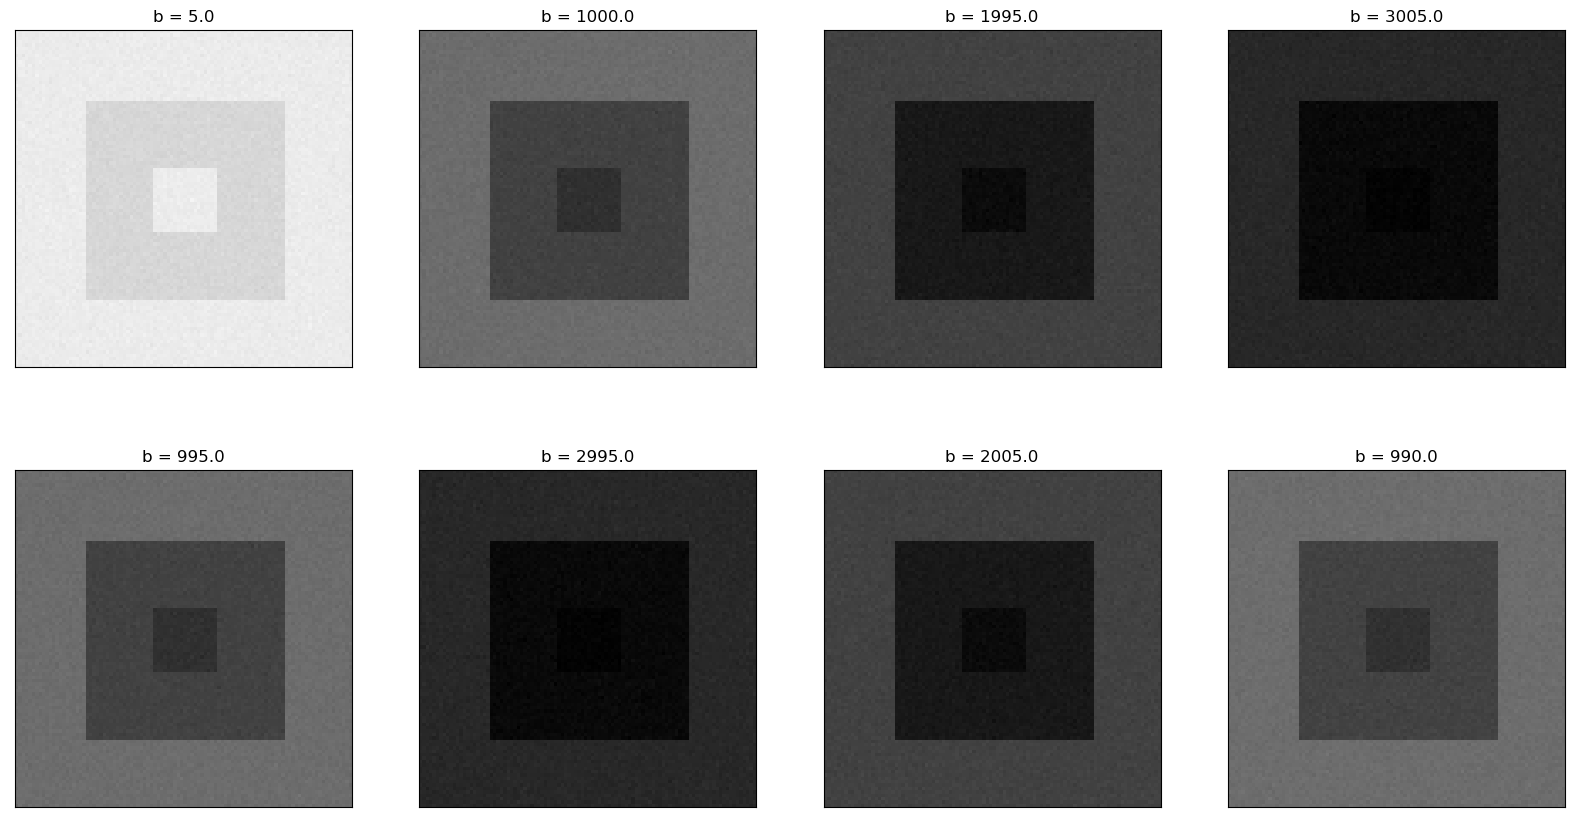

In [96]:
# define parameter values in the three regions
S0_region0, S0_region1, S0_region2 = 1500, 1400, 1600
Dp_region0, Dp_region1, Dp_region2 = 0.02, 0.04, 0.06
Dt_region0, Dt_region1, Dt_region2 = 0.0015, 0.0010, 0.0005
Fp_region0, Fp_region1, Fp_region2 = 0.1, 0.2, 0.3
# image size
sx, sy, sb = 100, 100, len(b_values)
# create image
dwi_image = np.zeros((sx, sy, sb))
Dp_truth = np.zeros((sx, sy))
Dt_truth = np.zeros((sx, sy))
Fp_truth = np.zeros((sx, sy))
print(dwi_image)
# fill image with simulated values
for i in range(sx):
    for j in range(sy):
        if (40 < i < 60) and (40 < j < 60):
            # region 0
            dwi_image[i, j, :] = S0_region0*ivim(b_values, Dp_region0, Dt_region0, Fp_region0)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region0, Dt_region0, Fp_region0
        elif (20 < i < 80) and (20 < j < 80):
            # region 1
            dwi_image[i, j, :] = S0_region1*ivim(b_values, Dp_region1, Dt_region1, Fp_region1)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region1, Dt_region1, Fp_region1
        else:
            # region 2
            dwi_image[i, j, :] = S0_region2*ivim(b_values, Dp_region2, Dt_region2, Fp_region2)
            Dp_truth[i, j], Dt_truth[i, j], Fp_truth[i, j] = Dp_region2, Dt_region2, Fp_region2
# add some noise
dwi_image_real = dwi_image + np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image_imag = np.random.normal(scale=15, size=(sx, sy, sb))
dwi_image = np.sqrt(dwi_image_real**2 + dwi_image_imag**2)
# plot simulated diffusion weighted image
fig, ax = plt.subplots(2, 4, figsize=(20,20))
b_id = 0
for i in range(2):
    for j in range(4):
        ax[i, j].imshow(dwi_image[:, :, b_id], cmap='gray', clim=(0, 1600))
        ax[i, j].set_title('b = ' + str(b_values[b_id]))
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        b_id += 1
plt.subplots_adjust(hspace=-0.6)
plt.show()


## Inference

Estimate IVIM parameter values for the simulated image.

In [97]:
# normalize signal
dwi_image_long = np.reshape(dwi_image, (sx*sy, sb))
S0 = np.expand_dims(dwi_image_long[:,0], axis=-1)
dwi_image_long = dwi_image_long[:,1:]/S0

net.eval()
with torch.no_grad():
    _, Dp, Dt, Fp = net(torch.from_numpy(dwi_image_long.astype(np.float32)))
    
Dp = Dp.numpy()
Dt = Dt.numpy()
Fp = Fp.numpy()

# make sure Dp is the larger value between Dp and Dt
if np.mean(Dp) < np.mean(Dt):
    Dp, Dt = Dt, Dp
    Fp = 1 - Fp

Plot parameter estimates and corresponding ground truths.

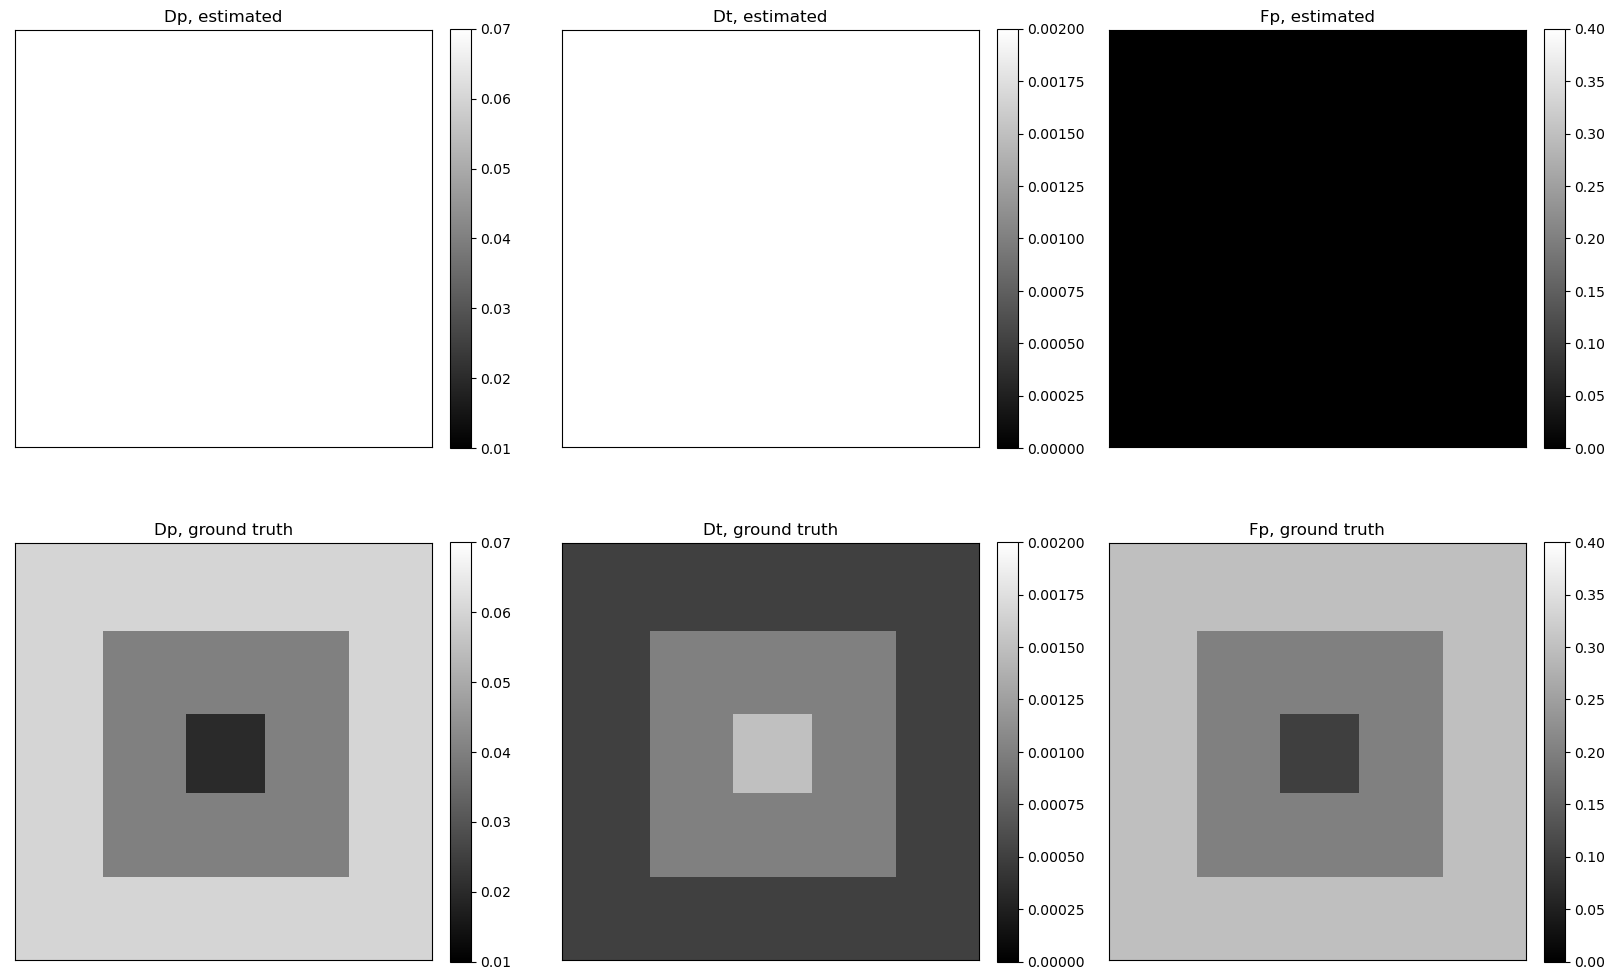

In [98]:
fig, ax = plt.subplots(2, 3, figsize=(20,20))

Dp_plot = ax[0,0].imshow(np.reshape(Dp, (sx, sy)), cmap='gray', clim=(0.01, 0.07))
ax[0,0].set_title('Dp, estimated')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
fig.colorbar(Dp_plot, ax=ax[0,0], fraction=0.046, pad=0.04)

Dp_t_plot = ax[1,0].imshow(Dp_truth, cmap='gray', clim=(0.01, 0.07))
ax[1,0].set_title('Dp, ground truth')
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
fig.colorbar(Dp_t_plot, ax=ax[1,0], fraction=0.046, pad=0.04)

Dt_plot = ax[0,1].imshow(np.reshape(Dt, (sx, sy)), cmap='gray', clim=(0, 0.002))
ax[0,1].set_title('Dt, estimated')
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
fig.colorbar(Dt_plot, ax=ax[0,1],fraction=0.046, pad=0.04)

Dt_t_plot = ax[1,1].imshow(Dt_truth, cmap='gray', clim=(0, 0.002))
ax[1,1].set_title('Dt, ground truth')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
fig.colorbar(Dt_t_plot, ax=ax[1,1], fraction=0.046, pad=0.04)

Fp_plot = ax[0,2].imshow(np.reshape(Fp, (sx, sy)), cmap='gray', clim=(0, 0.4))
ax[0,2].set_title('Fp, estimated')
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])
fig.colorbar(Fp_plot, ax=ax[0,2],fraction=0.046, pad=0.04)

Fp_t_plot = ax[1,2].imshow(Fp_truth, cmap='gray', clim=(0, 0.4))
ax[1,2].set_title('Fp, ground truth')
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])
fig.colorbar(Fp_t_plot, ax=ax[1,2], fraction=0.046, pad=0.04)

plt.subplots_adjust(hspace=-0.5)
plt.show()